In [87]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


In [88]:

## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations

In [3]:
## Choose a fire

In [89]:
snap = fv.prep_gdf(date = '20191031PM',handle_multi=True,only_lf=True,area_lim=4.7, index ='fireID',inplace=True)
snap.explore()

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:289: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:290: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


In [90]:
## Load up that fire 
fireID = '4655' # William Flatts
#fireID = '3956'
gdf = fv.load_large_fire(fireID)
gdf.explore(column='flinelen', style_kwds={'fillOpacity':0})

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


TypeError: Object of type Timestamp is not JSON serializable

In [91]:
gdf.columns

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat'],
      dtype='object')

In [92]:
## Get that fire lat lon

foi = gdf
foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
foi = foi.iloc[0] # First element
print(foi["Lat"])
foi["Lon"]

47.98391908284804


-118.43941779756635

In [93]:
## Look for closest station
st_cls = fv.closest(st_dict, foi)

The closest station is 79.0769966513209 km away.


In [94]:
## Get station Data
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:125: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [95]:
## Merge with fire data

full_fr = fv.fr_st_merge(gdf, st, sub = True)


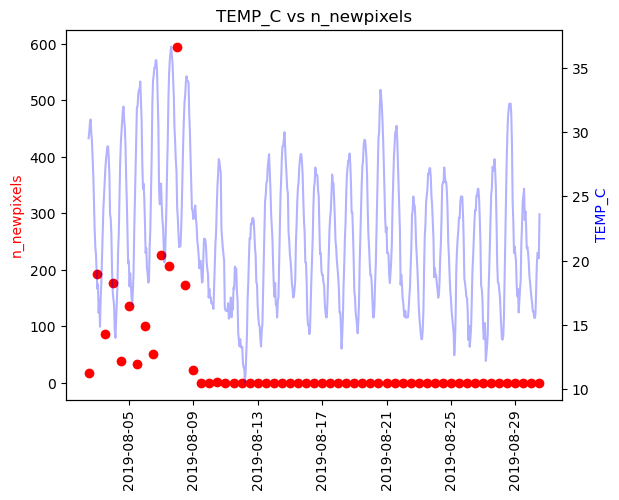

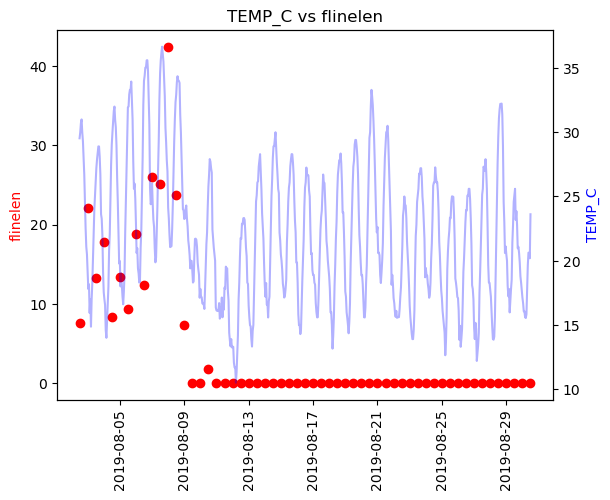

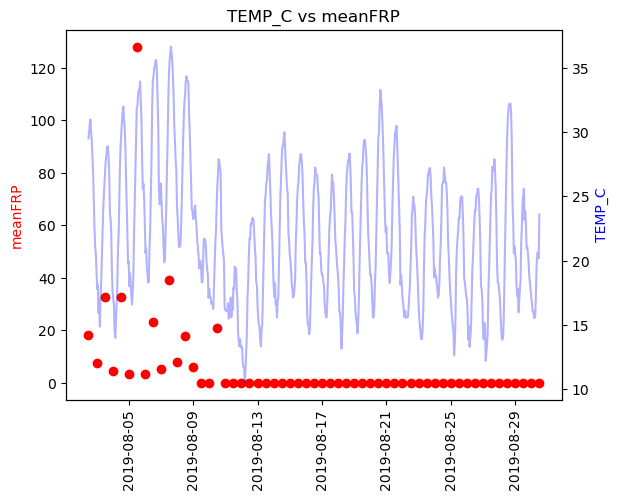

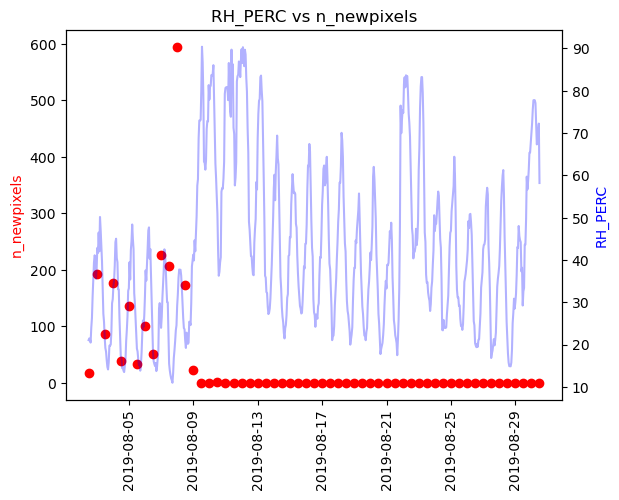

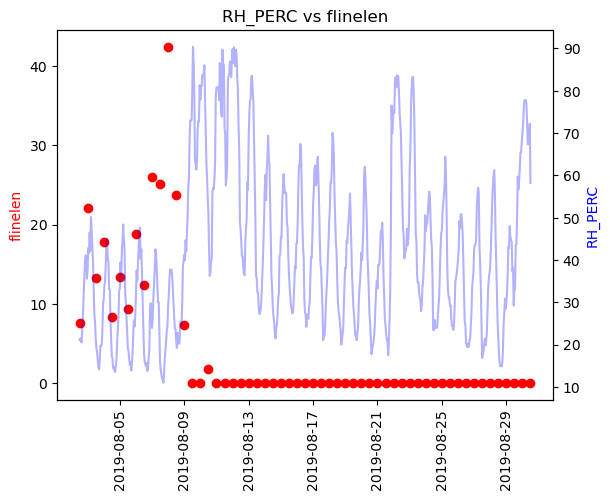

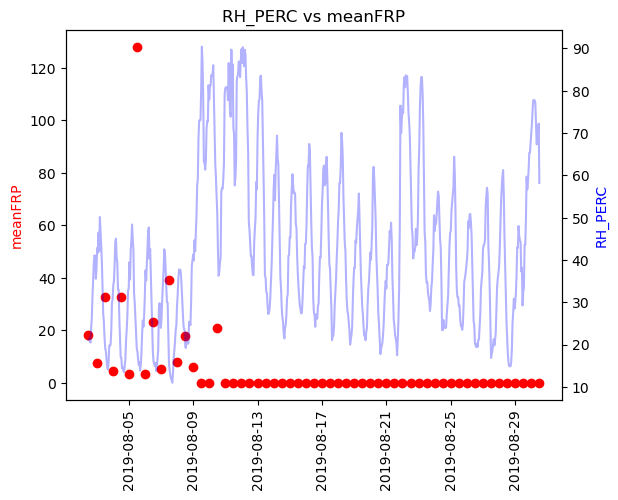

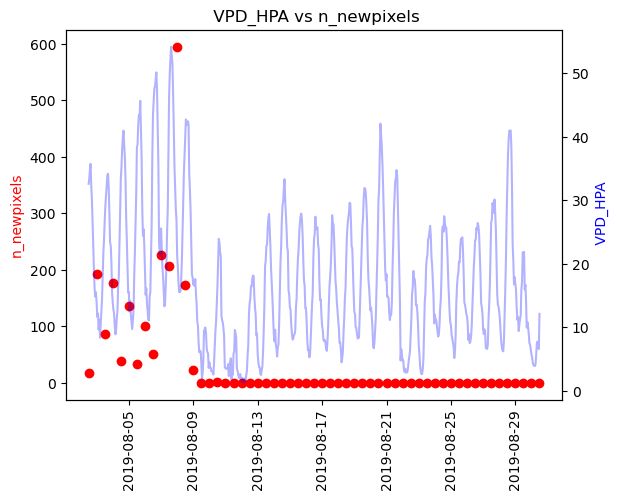

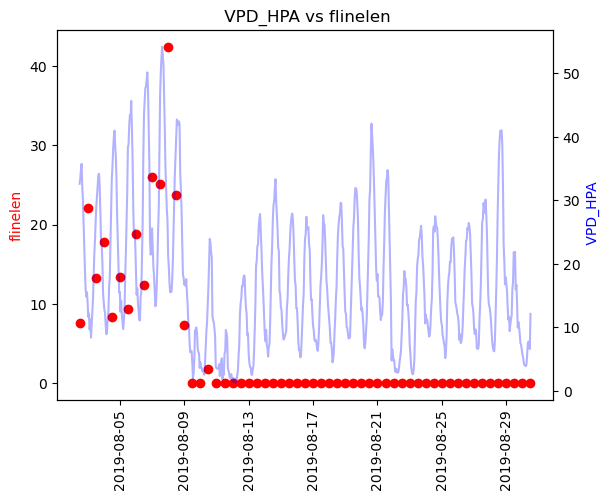

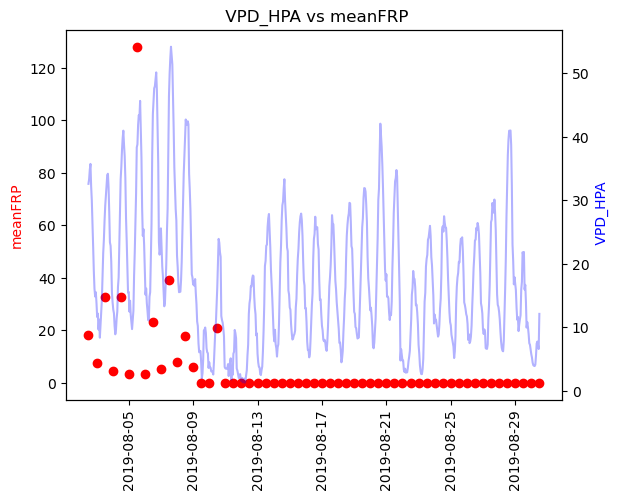

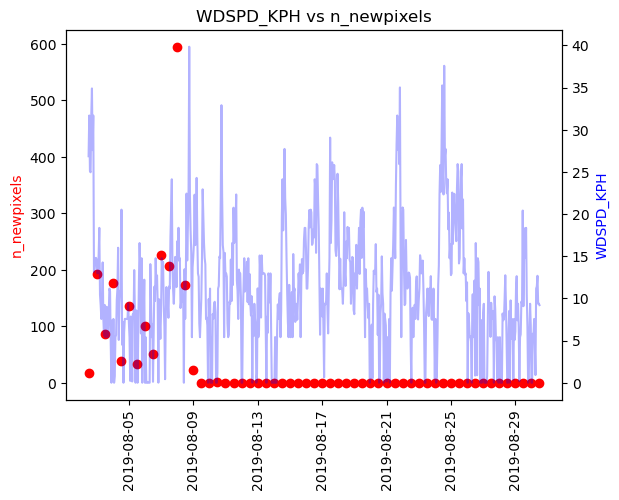

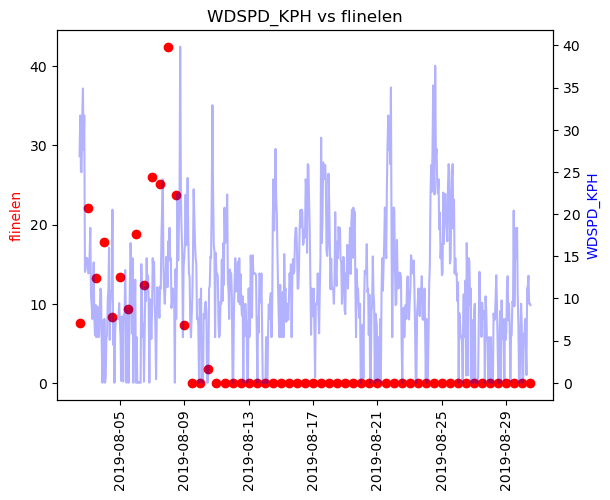

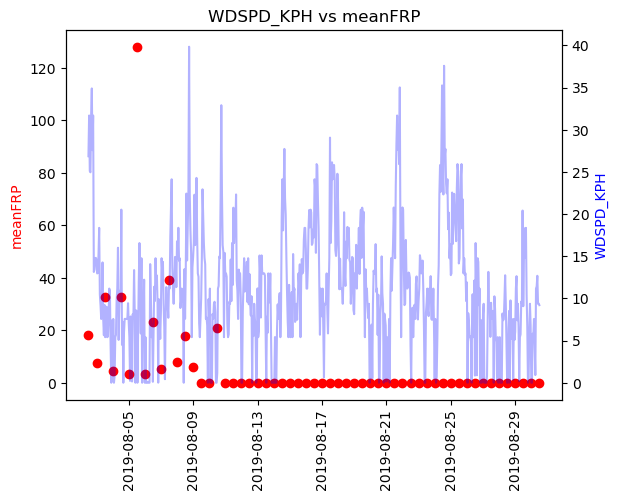

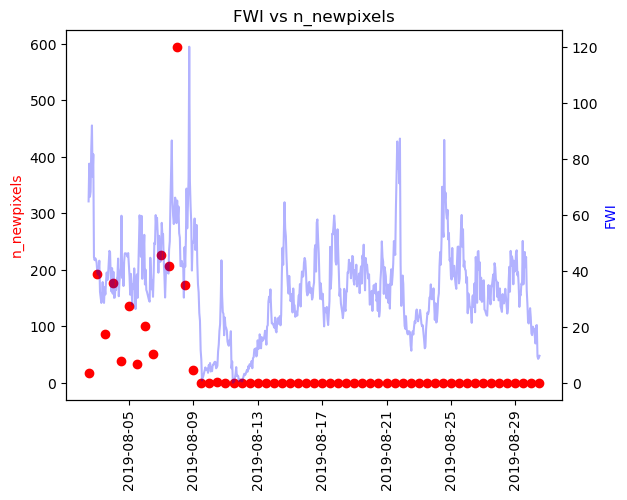

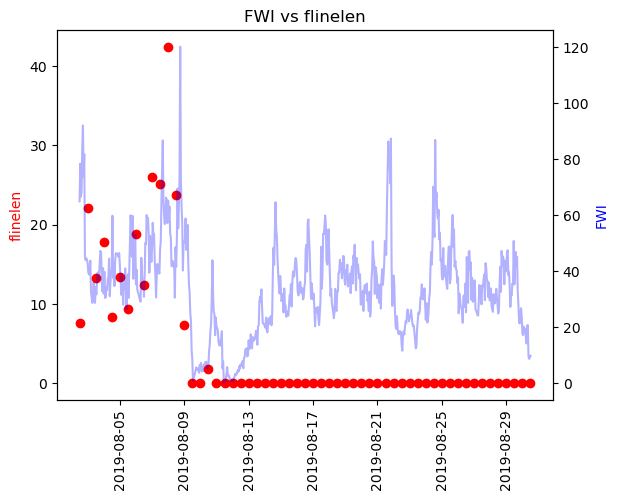

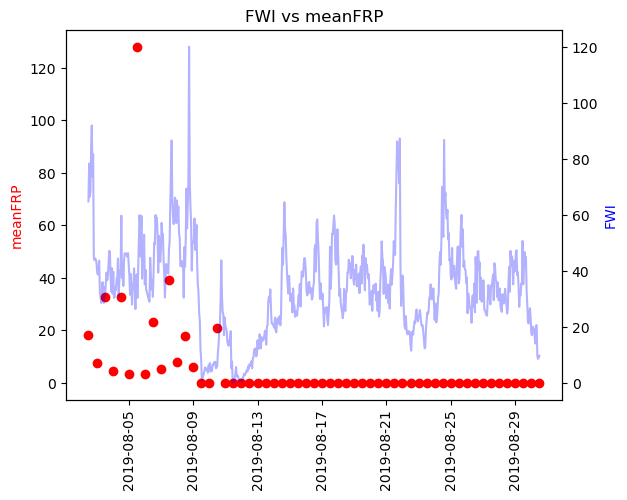

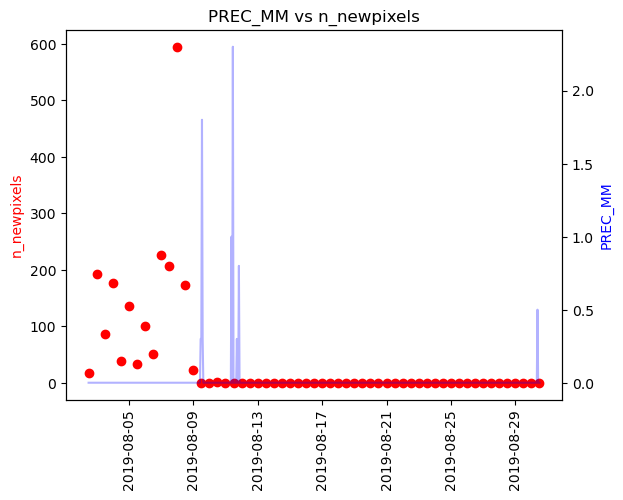

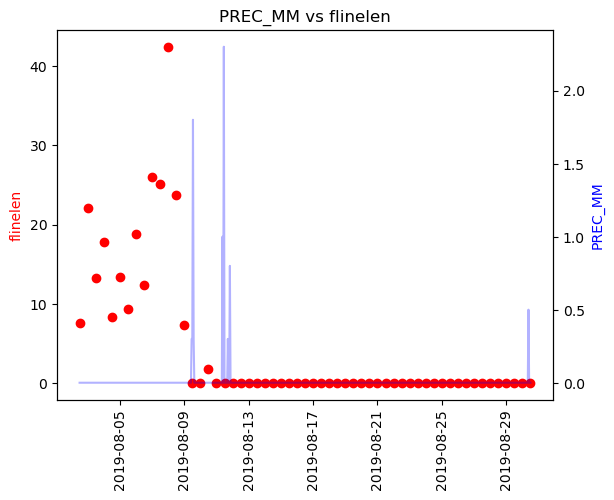

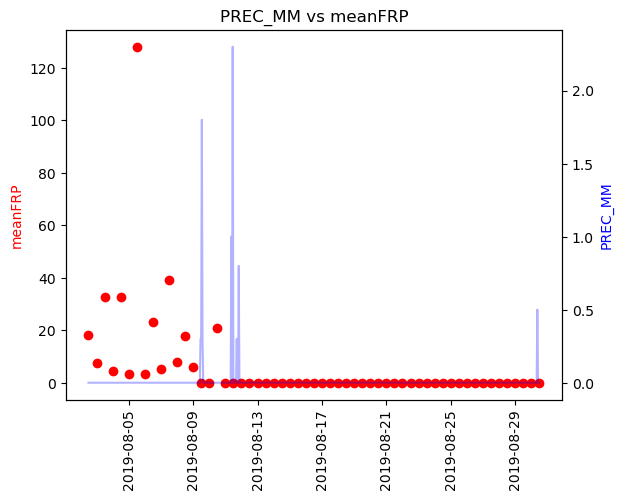

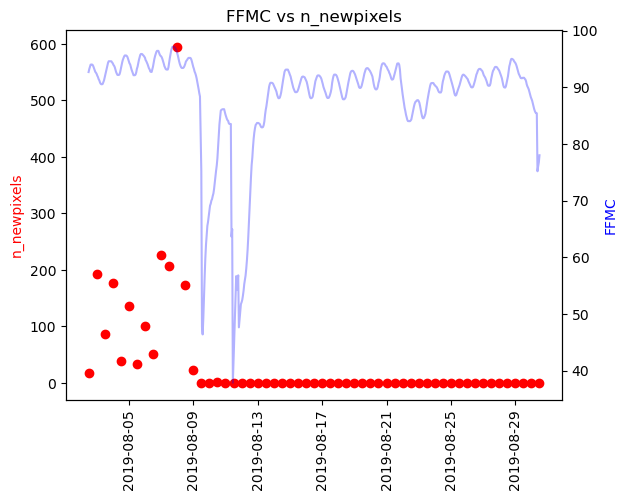

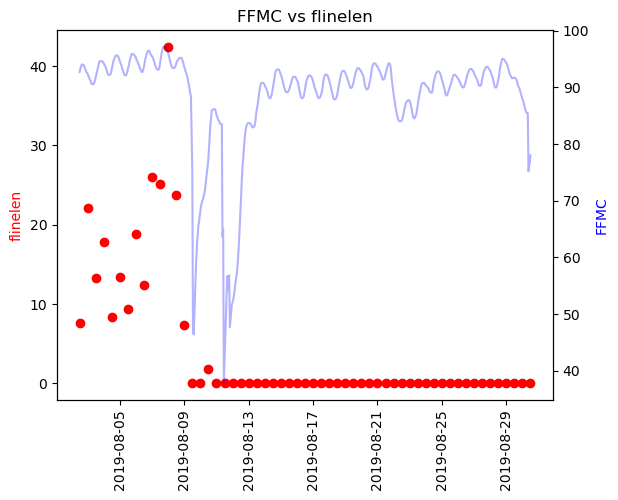

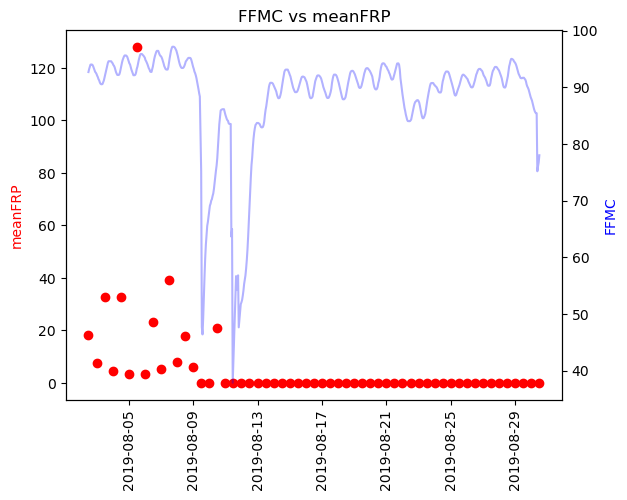

In [96]:
## Plot 

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', 'FFMC']  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

In [16]:
#import hvplot ## Need to have the extension going, and be on docker for this to work. 
#import hvplot as hv

In [97]:
long_time = fv.fr_st_merge(gdf, st, sub = False) # Get full station timeseries 
long_time = long_time.set_index("t")

In [18]:
#long_time.columns

In [19]:
#import hvplot.pandas
#import holoviews as hv
#import hvplot.geoviews

#pd.options.plotting.backend = 'holoviews'
#hvplot.extension('bokeh')
#hv.extension('bokeh')
#hv.extension('matplotlib')
#hvplot.extension('matplotlib')

In [20]:
#tmp = long_time[[ "FWI", "flinelen", "meanFRP", ' VPD_HPA', 'RH_PERC', 'TEMP_C', 'WDSPD_KPH']]
#tmp = tmp[np.isfinite(tmp)]
#meanFRP = tmp[np.isfinite(tmp.meanFRP)]
#flinelen = tmp[np.isfinite(tmp.flinelen)]

#long_time.hvplot( y = "FWI")

In [21]:
#tmp.hvplot()

In [22]:
#flinelen.hvplot.scatter( y='flinelen', color = "red", yaxis = "left") * tmp.hvplot.line(y = "FWI", yaxis = "right") 

In [23]:
# No HVplot

In [24]:
#mid_fire


In [98]:
full_fr["fwi_anom"] = full_fr["FWI"] - np.mean(long_time.FWI)


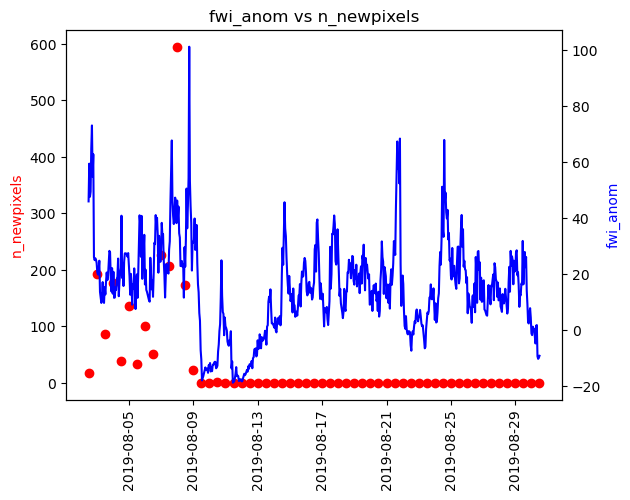

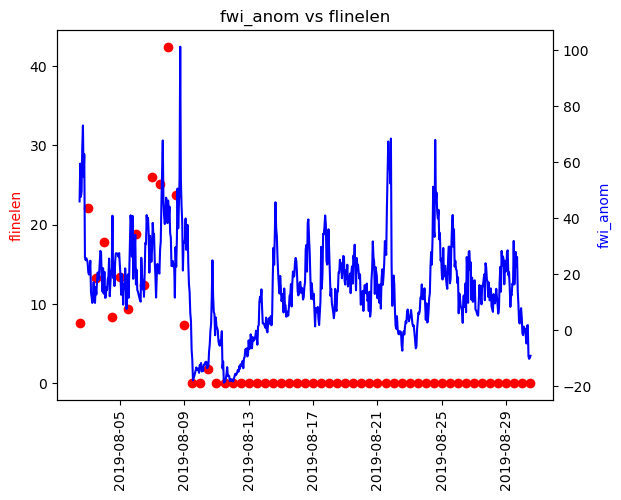

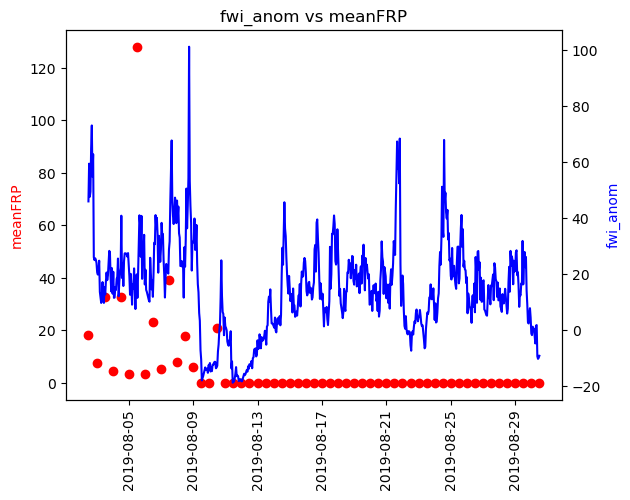

In [99]:
#tmp_fire = long_fire[]

met = ["fwi_anom"]  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot


for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

In [100]:
# Plotting a month beforehand 
import datetime as dt

In [101]:
#st_dat = dat[(dat.time >= min(gdf.t)) &  (dat.time <= max(gdf.t))]

start_date = min(full_fr["t"])
print(start_date)

month_early = start_date - np.timedelta64(5, 'M')
month_early

2019-08-02 12:00:00


Timestamp('2019-03-03 07:34:30')

In [102]:
mid_fire = fv.fr_st_merge(gdf, st, sub = True, sub_type = "month_before", num_months= 1)

ConversionError: Failed to convert value(s) to axis units: '2020-09-06 00:30:00'

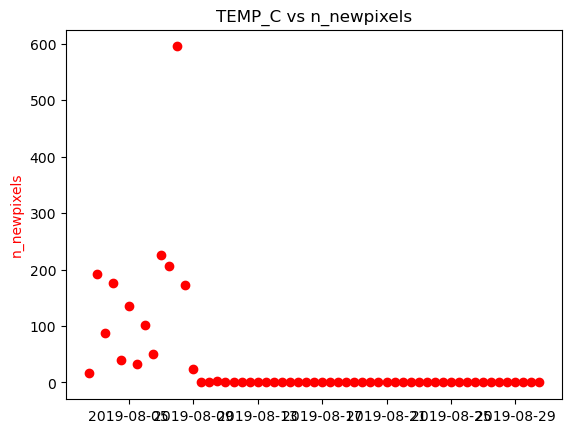

In [103]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot



for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(mid_fire["t"], mid_fire[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax.axvline(x="2020-09-06 00:30:00", ymin=0, ymax=3000, color = "orange")
        ax.axvline(x="2020-09-06 12:30:00", ymin=0, ymax=3000, color = "orange")
        ax2=ax.twinx()
        ax2.plot(mid_fire["t"], mid_fire[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()
        
        

ConversionError: Failed to convert value(s) to axis units: '2020-09-06 00:30:00'

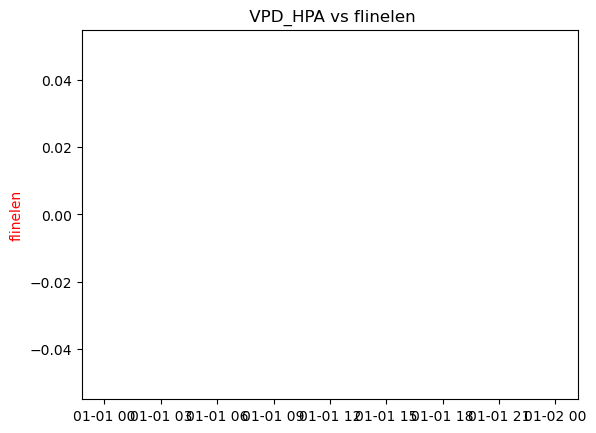

In [104]:
creek_fire  = mid_fire[(mid_fire["t"] >= "2020-09-01 00:00:00")]
#creek_fire  = mid_fire[(mid_fire["t"] >= "2020-09-01 00:00:00") & (mid_fire["t"] <= "2020-09-15 00:00:00")]

met = [
       ' VPD_HPA']  ## Station Data Columns to Plot
fire = ['flinelen','meanFRP',] ## gdf columns to plot
#fire = ['flinelen']
#fire = ['meanFRP']

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(creek_fire["t"], creek_fire[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax.axvline(x="2020-09-06 00:30:00", ymin=0, ymax=3000, color = "orange")
        ax.axvline(x="2020-09-06 12:30:00", ymin=0, ymax=3000, color = "orange")
        ax2=ax.twinx()
        ax2.plot(creek_fire["t"], creek_fire[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

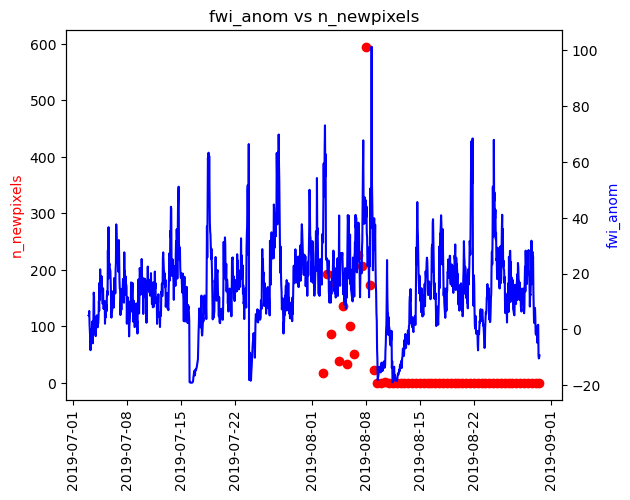

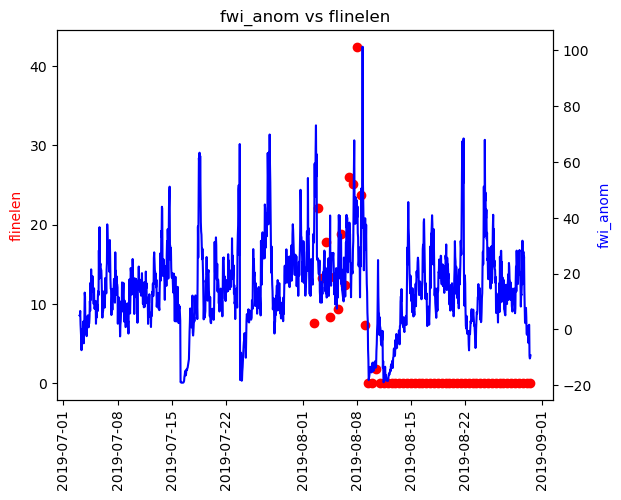

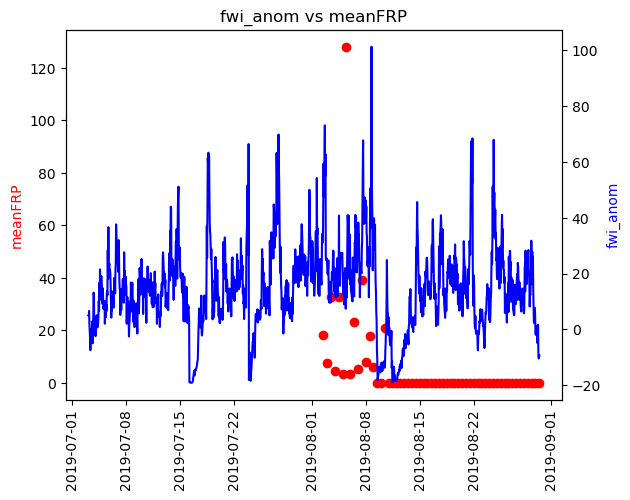

In [105]:
# look at anomolies

mid_fire["fwi_anom"] = mid_fire["FWI"] - np.mean(long_time.FWI)


met = ["fwi_anom"]  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot



for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(mid_fire["t"], mid_fire[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(mid_fire["t"], mid_fire[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()


In [106]:
# Explanatory variables


exp = fv.fr_st_merge(gdf, st)
exp

n_pixels  n_newpixels       farea     fperim  flinelen  duration  \
8        17.0         17.0    2.991894   7.507975  7.507975       0.0   
57        NaN          NaN         NaN        NaN       NaN       NaN   
58        NaN          NaN         NaN        NaN       NaN       NaN   
59        NaN          NaN         NaN        NaN       NaN       NaN   
60        NaN          NaN         NaN        NaN       NaN       NaN   
..        ...          ...         ...        ...       ...       ...   
669       NaN          NaN         NaN        NaN       NaN       NaN   
670       NaN          NaN         NaN        NaN       NaN       NaN   
671       NaN          NaN         NaN        NaN       NaN       NaN   
672       NaN          NaN         NaN        NaN       NaN       NaN   
14     2057.0          0.0  185.537556  70.933416  0.000000       8.0   

        pixden    meanFRP                   t  \
8     5.682019  18.326471 2019-08-02 12:00:00   
57         NaN        NaN 2019-08-02 13:00:00   
58         NaN        NaN 2019-08-02 14:00:00   
59         NaN        NaN 2019-08-02 15:00:00   
60         NaN        NaN 2019-08-02 16:00:00   
..         ...        ...                 ...   
669        NaN        NaN 2019-08-30 08:00:00   
670        NaN        NaN 2019-08-30 09:00:00   
671        NaN        NaN 2019-08-30 10:00:00   
672        NaN        NaN 2019-08-30 11:00:00   
14   11.086704   0.000000 2019-08-30 12:00:00   

                                              geometry  ...      DC     BUI  \
8    POLYGON ((-118.57549 47.95257, -118.57572 47.9...  ...  628.69  157.71   
57                                                None  ...     NaN     NaN   
58                                                None  ...     NaN     NaN   
59                                                None  ...     NaN     NaN   
60                                                None  ...     NaN     NaN   
..                                                 ...  ...     ...     ...   
669                                               None  ...     NaN     NaN   
670                                               None  ...     NaN     NaN   
671                                               None  ...     NaN     NaN   
672                                               None  ...     NaN     NaN   
14   POLYGON ((-118.57855 47.95313, -118.57869 47.9...  ...  828.85  207.89   

         ISI      FWI  OBSMINUTEDIFFTEMP OBSMINUTEDIFFRH  OBSMINUTEDIFFWDSPD  \
8    24.2460  64.9260                7.0             7.0                 7.0   
57   33.2560  78.4140                0.0             0.0                 0.0   
58   25.2820  66.5870                7.0             7.0                 7.0   
59   26.4240  68.3790                7.0             7.0                 7.0   
60   37.2280  83.7900                0.0             0.0                 0.0   
..       ...      ...                ...             ...                 ...   
669   3.9633  20.7420                7.0             7.0                 7.0   
670   1.4644   9.5784                7.0             7.0                 7.0   
671   1.3052   8.6800                0.0             0.0                 0.0   
672   1.3712   9.0568                7.0             7.0                 7.0   
14    1.4964   9.7720                7.0             7.0                 7.0   

     OBSMINUTEDIFFPREC  OBSMINUTEDIFFSNOW  HH_format  
8                    7                NaN         12  
57                   0                NaN         13  
58                   7                NaN         14  
59                   7                NaN         15  
60                   0                NaN         16  
..                 ...                ...        ...  
669                  7                NaN         08  
670                  7                NaN         09  
671                  0                NaN         10  
672                  7                NaN         11  
14                   7  

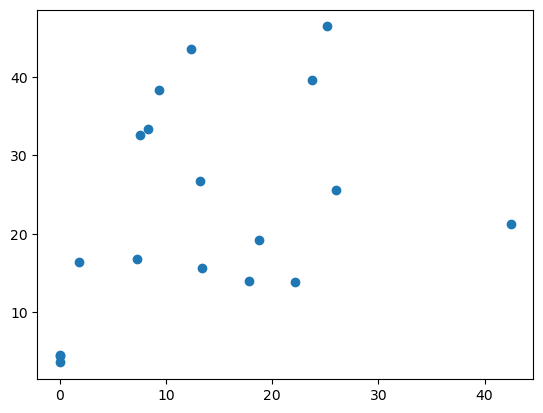

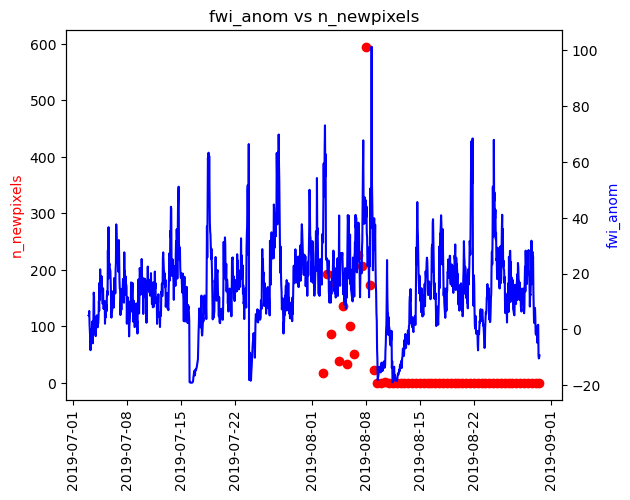

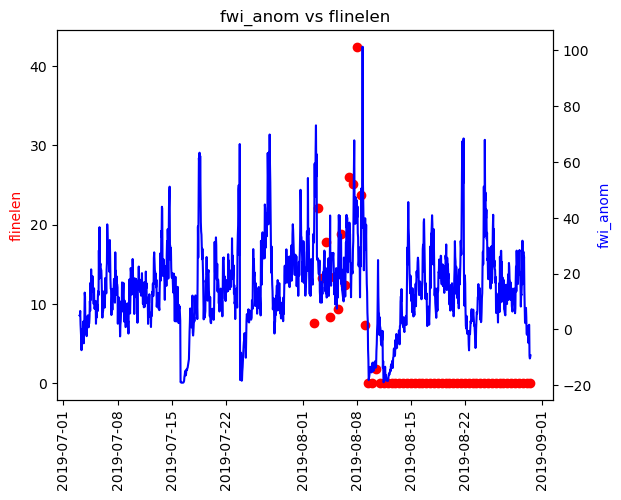

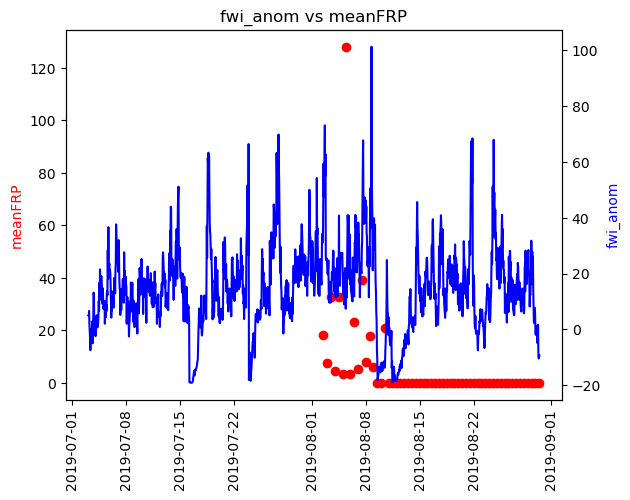

In [107]:
exp = exp[exp.t < "2019-08-11 12:00:00"]
exp.columns

plt.scatter(x = exp.flinelen, y = exp[' VPD_HPA'])

met = ["fwi_anom"]  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot



for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(mid_fire["t"], mid_fire[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(mid_fire["t"], mid_fire[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    FWI   No. Observations:                  216
Model:                     AutoReg(3)   Log Likelihood                -760.245
Method:               Conditional MLE   S.D. of innovations              8.587
Date:                Mon, 07 Nov 2022   AIC                           1530.490
Time:                        17:32:32   BIC                           1547.296
Sample:                             3   HQIC                          1537.282
                                  216                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8453      1.355      2.099      0.036       0.189       5.502
FWI.L1         0.7062      0.069     10.292      0.000       0.572       0.841
FWI.L2         0.2394      0.082      2.930      0.003       0.079       0.400
FWI.L3        -0.0298      0.068     -0.437      0.662      -0.164       0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0761           +0.0000j            1.0761            0.0000
AR.2           -3.1003           +0.0000j            3.1003            0.5000
AR.3           10.0517           +0.0000j           10.0517            0.0000
-----------------------------------------------------------------------------
"""

In [40]:
import seaborn as sns ## I mannually conda installed these into the fireatlas env. Will need to be reinstalled.
import statsmodels.api as sm
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [39]:
mod = AutoReg(exp.FWI, 3)
res = mod.fit()
res.summary()

/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    FWI   No. Observations:                  216
Model:                     AutoReg(3)   Log Likelihood                -760.245
Method:               Conditional MLE   S.D. of innovations              8.587
Date:                Mon, 07 Nov 2022   AIC                           1530.490
Time:                        17:42:57   BIC                           1547.296
Sample:                             3   HQIC                          1537.282
                                  216                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8453      1.355      2.099      0.036       0.189       5.502
FWI.L1         0.7062      0.069     10.292      0.000       0.572       0.841
FWI.L2         0.2394      0.082      2.930      0.003       0.079       0.400
FWI.L3        -0.0298      0.068     -0.437      0.662      -0.164       0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0761           +0.0000j            1.0761            0.0000
AR.2           -3.1003           +0.0000j            3.1003            0.5000
AR.3           10.0517           +0.0000j           10.0517            0.0000
-----------------------------------------------------------------------------
"""

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat', 'YYYY', 'MM', 'DD',
       'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH', 'PREC_MM',
       'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format'],
      dtype='object')


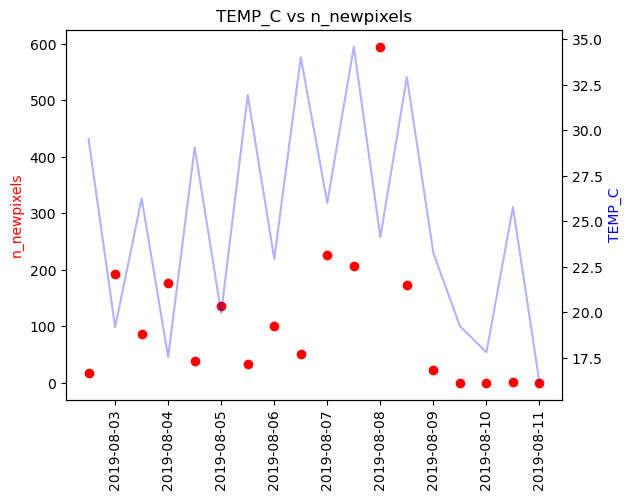

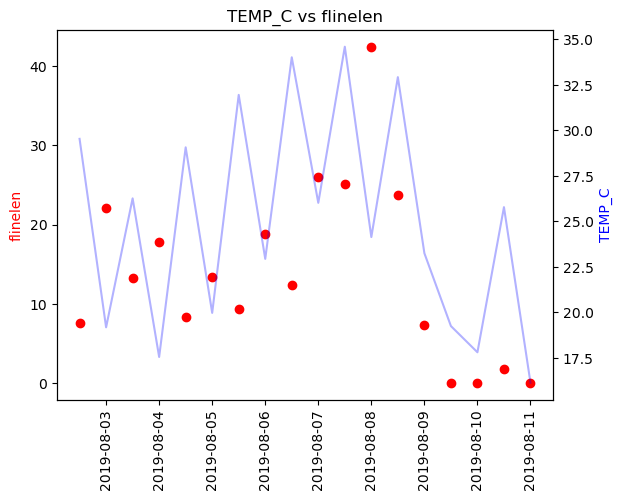

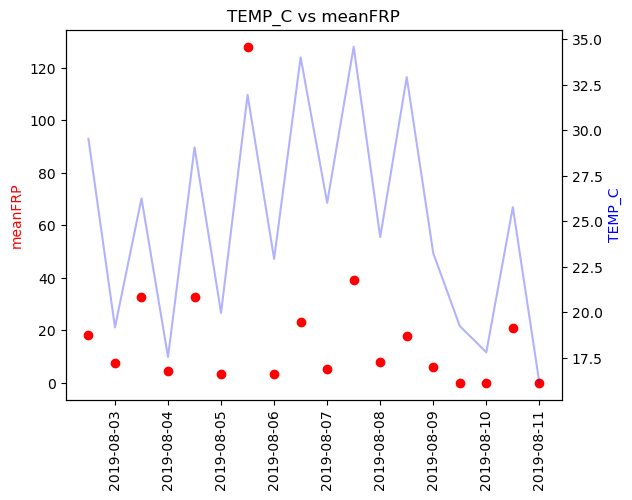

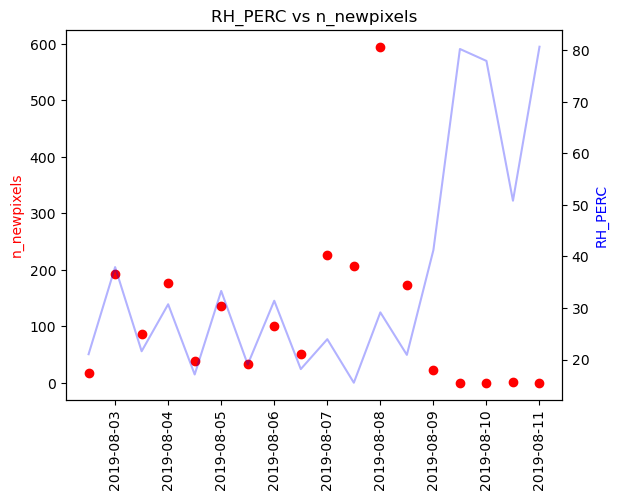

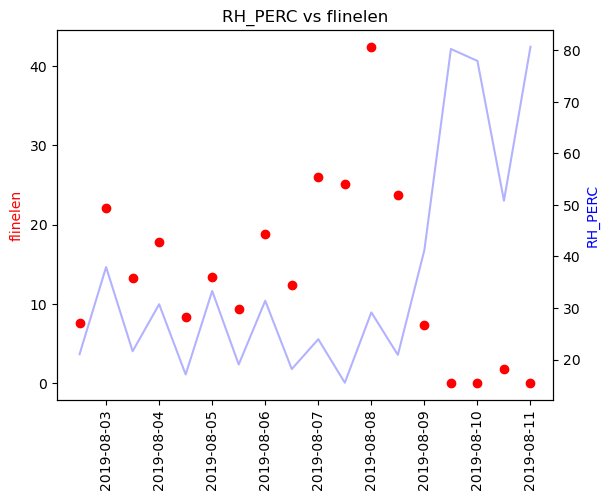

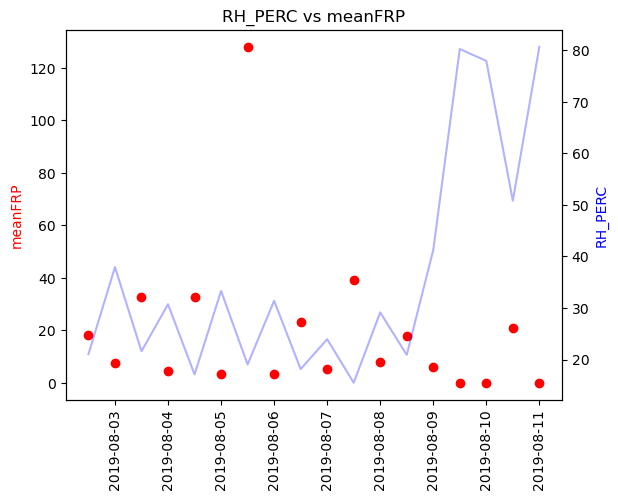

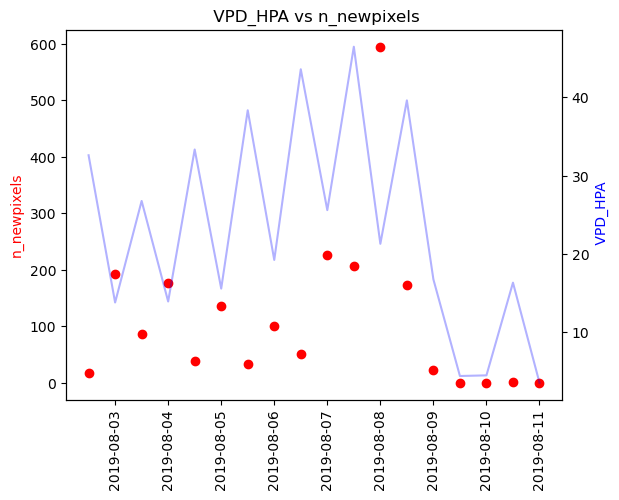

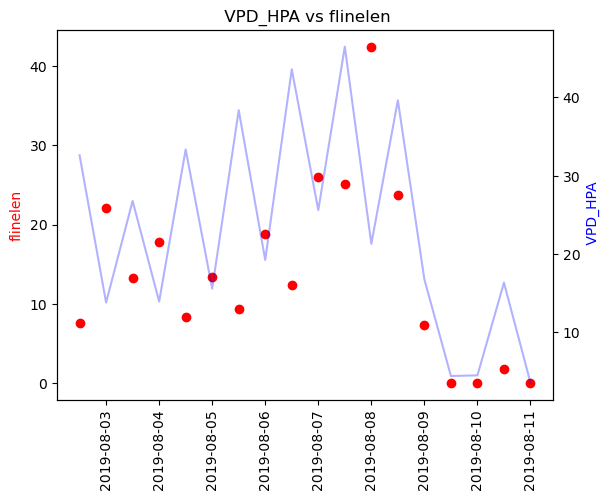

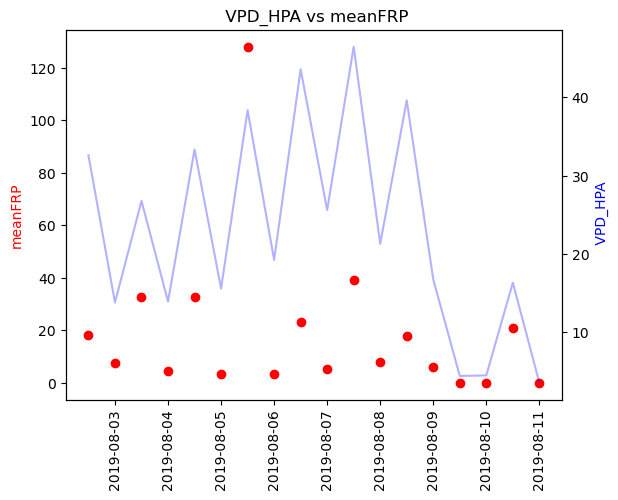

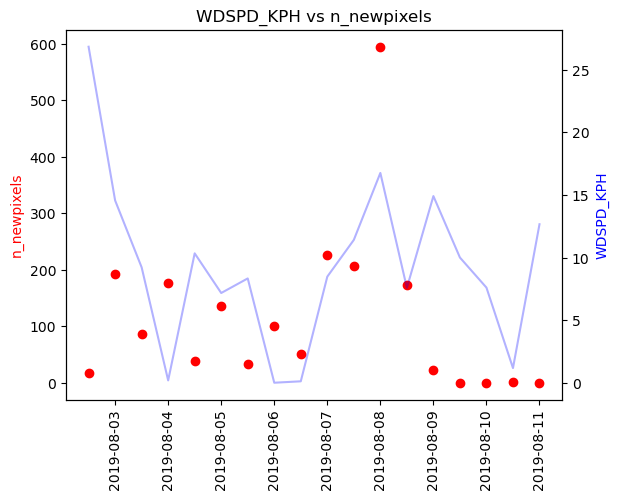

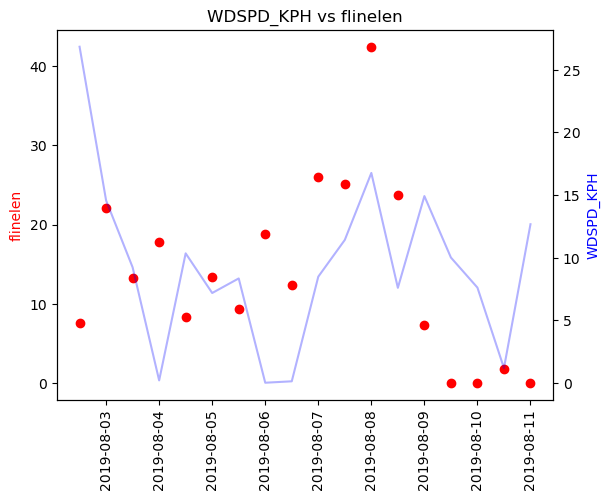

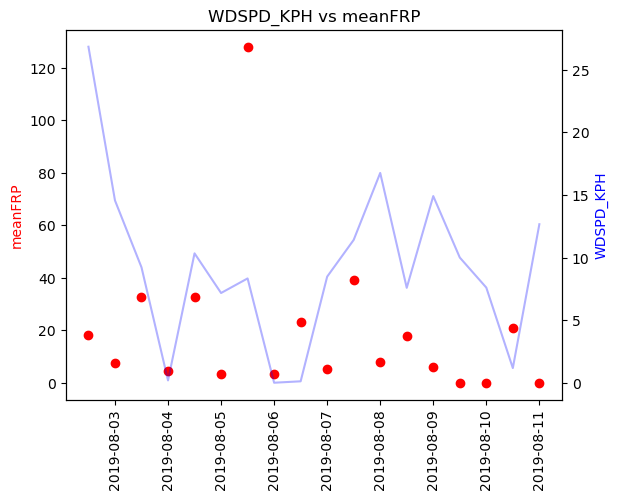

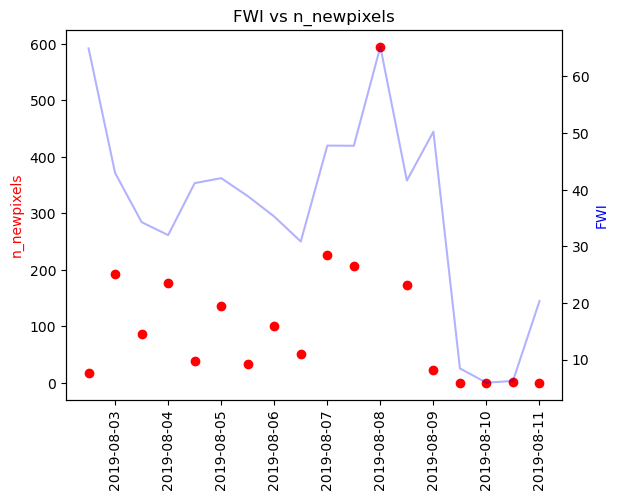

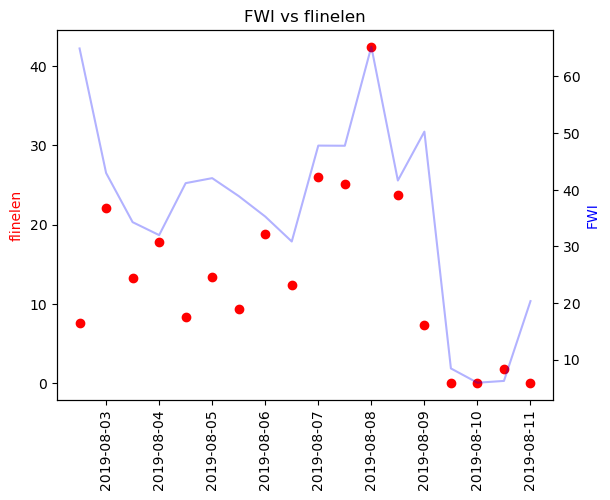

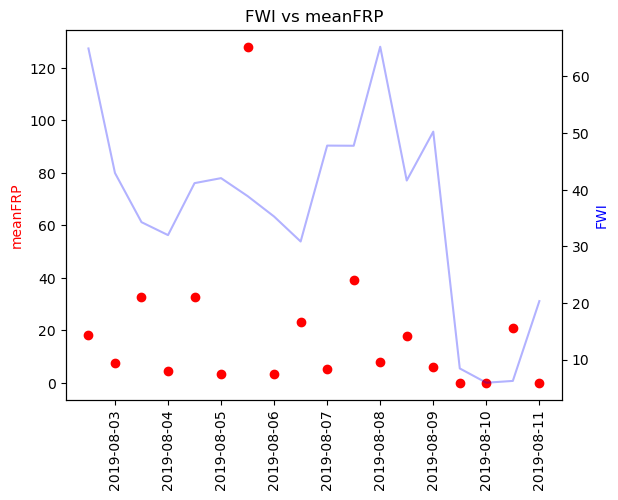

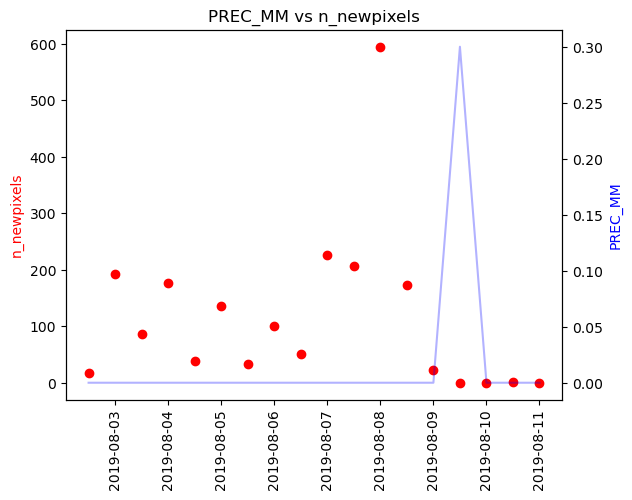

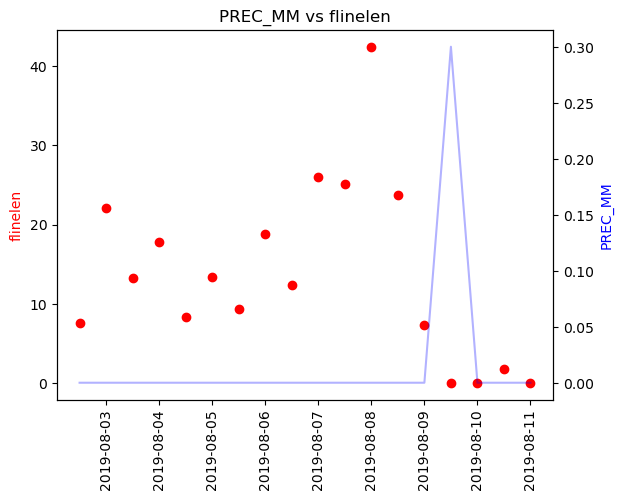

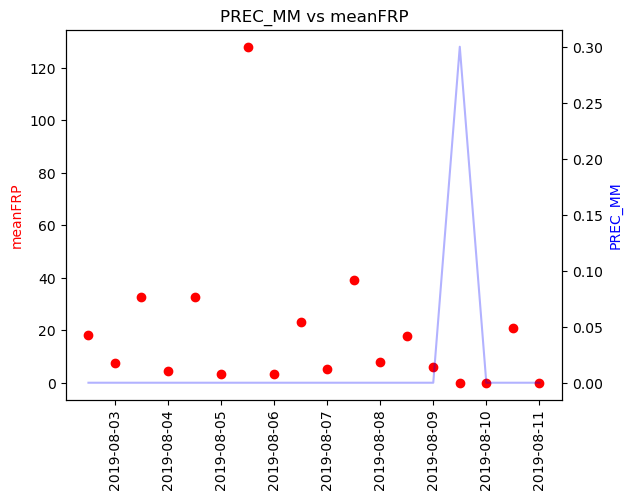

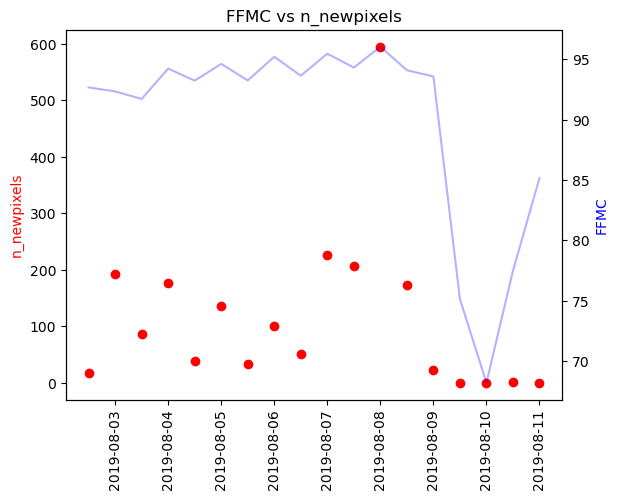

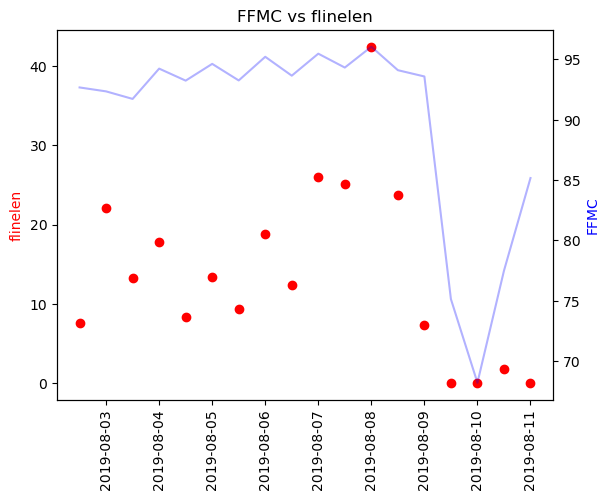

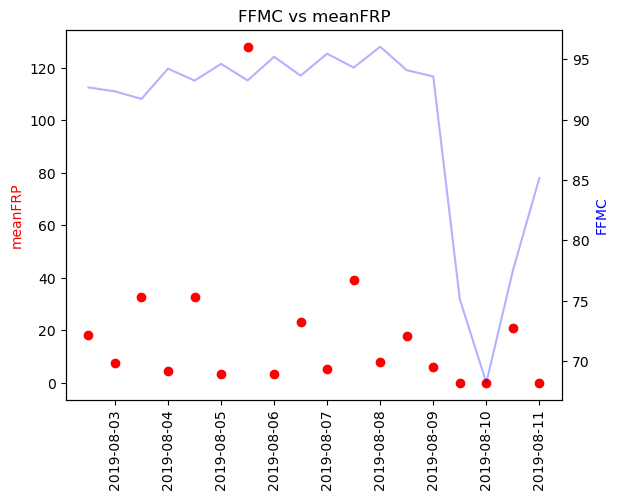

In [86]:
## Try GLM
#glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
tmp = exp[exp.flinelen.isin(exp.flinelen.dropna())]
print(tmp.columns)
exo = tmp[['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH', 'PREC_MM',
       'SNOWD_M', 'FFMC', 'ISI', 'FWI']]

exo_small = tmp[[' VPD_HPA', 'WDSPD_KPH', 'PREC_MM']]

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', 'FFMC']  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(tmp["t"], tmp[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(tmp["t"], tmp[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

In [78]:
glm = sm.GLM(tmp.flinelen, exo )# ,family=sm.families.Binomial()
glm_2 = sm.GLM(tmp.flinelen, exo_small )
res = glm.fit()
res2 = glm_2.fit()
print(res.summary())
print('Parameters: ', res.params)
print('T-values: ', res.tvalues)


                 Generalized Linear Model Regression Results                  
Dep. Variable:               flinelen   No. Observations:                   18
Model:                            GLM   Df Residuals:                       10
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          71.044
Method:                          IRLS   Log-Likelihood:                -58.621
Date:                Mon, 07 Nov 2022   Deviance:                       710.44
Time:                        18:18:12   Pearson chi2:                     710.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7211
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TEMP_C        -0.6500      1.883     -0.345      0.7

In [79]:
print(res2.summary())
print('Parameters: ', res2.params)
print('T-values: ', res2.tvalues)


                 Generalized Linear Model Regression Results                  
Dep. Variable:               flinelen   No. Observations:                   18
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          127.49
Method:                          IRLS   Log-Likelihood:                -67.533
Date:                Mon, 07 Nov 2022   Deviance:                       1912.4
Time:                        18:18:13   Pearson chi2:                 1.91e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1162
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
 VPD_HPA       0.4221      0.146      2.893      0.0

In [84]:
res2.pvalues

 VPD_HPA     0.003810
WDSPD_KPH    0.308010
PREC_MM      0.643191
dtype: float64